## Example Notebook on training a MaxxVit Transformer Encoder and Decoder Image Captioning Model
What to expect:
1. Application of custom data loaders
2. Application of image captioning model with transformers (maxxvit)
3. Application of BLEU and ROGUE
4. Application of model training, validation and test
4. Application of model inference

- Note: Due to the limitation of relative imports in notebooks, the full codes from src/helper functions have been copy pasted here to prevent the need for running imports
- Proper python functions in src/main.py will be rely on imports

Image Size for MaxVit (finetuned) must be (224,224) but for MaxxVit (pre-trained) must be (256,256)

In [110]:
# Standard library imports
import math

# Third-party imports
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import timm
import torch
from torch import Tensor, optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models

### 1. Application of custom data loaders

#### Imports

In [111]:
# Tokenizer to split sentences into a list of words
word_tokenizer = spacy.load("en_core_web_sm")

class Vocabulary():
  """
  Class to convert the captions to index sequential tensors

  Args:
    freq_threshold (int, optional): How many times a word has to appear in dataset before it can be added to the vocabulary. Defaults to 2
  """

  def __init__(self, freq_threshold:int=2):
    self.itos={ 0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>" } # index to sentence
    self.stoi={ "<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3 } # sentence to index
    self.freq_threshold = freq_threshold # threshold for adding a word to the vocab

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    # convert sentence to list of words
    return [tok.text.lower() for tok in word_tokenizer.tokenizer(text)] # convert sentence to words


  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4 # 0-3 are for special tokens

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence): # convert sentence to words
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold: # once met freq_threshold, add to vocab list
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text) # convert annotations to labels by converting each word to the index inside the vocab, else UNK tag
    
    result = []

    for token in tokenized_text:
      if token in self.stoi:
        result.append(self.stoi[token])
      else:
        result.append(self.stoi["<UNK>"])
            
    return result

In [112]:
class CustomDataset(Dataset):

    """
    Class to setup the custom Dataset for pyTorch Dataloader

    Args:
        Note: the order of the csv_file and root_dir are directly related, csv_file[0] contains captions for images in root_dir[0]
        
        csv_file (list): Lists of path to CSV files with annotations.
        root_dir (list): List of directory containing images.
        img_size (tuple, optional): Image size in the format (width, height), defaults to (256,256)
        transform (callable, optional): Optional torchvision transform to be applied on a sample, defaults to None
        freq_threshold (int, optional): Freq threshold for Vocabulary Class, defaults to 2
        vocabulary (Vocabulary, optional): Determines to use an existing vocabulary or create own, defaults to None
    Returns:
        image: transformed image
        labels: tensor object of the labels
        all_image_captions: list containing all the captions of the image
    """

    def __init__(self, csv_file:list, root_dir:list, img_size:tuple=(256,256), transform=None, freq_threshold=2, vocabulary=None):
        
        #dataframe with col name ['image_filename', 'image_captions'] from csv file
        self.annotations = pd.DataFrame()
        #list containing the int boundary on which image path to look at
        #list will containing the num of images in directory which is the boundary
        self.root_dir_boundary = []
        
        for idx, label_files in enumerate(csv_file): 
            labels = pd.read_csv(label_files, index_col=0) #remove index col
            self.annotations = pd.concat([self.annotations, labels], ignore_index=True) #merging annotations into 1 dataset

            #getting the image boundary on which idx belongs to which image file path
            if idx == 0: 
                self.root_dir_boundary.append(len(labels))
            else:
                #get the number of images in root directory and add with the previous to get the range of index that are in this filepath
                self.root_dir_boundary.append(self.root_dir_boundary[idx-1] + len(labels))

        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        #initialise vocabulary
        if vocabulary == None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.annotations.iloc[:,1].to_list()) #build vocab with all captions
        else:
            self.vocab = vocabulary

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.annotations.iloc[idx, 0] #Image name as column 0
        #finding the correct root directory filepath in the list does the image belong to
        image_dir_idx = 0
        while idx >= self.root_dir_boundary[image_dir_idx] and image_dir_idx < len(self.root_dir_boundary):
            image_dir_idx += 1

        img_path = f"{self.root_dir[image_dir_idx]}/{img_name}"

        image = Image.open(img_path)
        # image = ImageOps.pad(image, self.img_size) #resize image
        annotation = self.annotations.iloc[idx, 1] #Annotation as column 1
        
        #converting caption to index tensor
        numercalized_annotations = [self.vocab.stoi["<SOS>"]]
        numercalized_annotations += self.vocab.numericalize(annotation)
        numercalized_annotations.append(self.vocab.stoi["<EOS>"])

        #create list of all captions associated with the image (for BLEU & ROUGE score)
        all_img_captions = self.annotations[self.annotations['image_filename'] == img_name]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(numercalized_annotations), all_img_captions.iloc[:,1].to_list()


In [113]:
class padAnnotations():
  """
    A custom collate function for PyTorch DataLoader to handle batching of images and captions.    
    This collate function is used to dynamically pad the captions in a batch to the same length so that they can be processed as a batch. 

    Args:
      pad_idx (int): The index of the PAD token in the vocabulary, used for padding shorter captions in a batch to match the longest caption.
        
    Returns: 
      img: batch image object
      labels: batch of tensors of the captions, converted to the same length by adding <PAD>
      all_labels: batch of lists of the captions of the images
  """
  
  def __init__(self, pad_idx:int, batch_first:bool=False):
    self.batch_first = batch_first
    self.pad_idx = pad_idx
      
  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
    all_labels = [item[2] for item in batch]

    return imgs, targets, all_labels

In [114]:
def visualise_img_caption_data(dataloader, batch_size: int, dataset: CustomDataset, num_batches: int = 1, num_samples: int=9):
    """
    Function to visualise the dataset

    Args:
        dataloader (dataloader object): Pytorch dataloader object to visualise
        batch_size (int): Batch Size of dataloader
        dataset (CustomDataset): dataset used to create dataloader (required to get the vocabulary)
        num_batches (int, optional): How many batches to visualise, defaults to 1
        num_samples (int, optional): How many images per batch to visualise, defaults to 9

    Returns:
        Plot of image with its caption and the list of the captions to the image
    """

    for i in range(num_batches):
        train_features, train_labels, train_all_captions = next(iter(dataloader))
        if i == 0:  # Print shape
            print(f"Feature batch shape: {train_features.size()}")
            print(f"Labels batch shape: {train_labels.size()}")
            print(f"All captions batch size: {len(train_all_captions)}")

        for j in range(num_samples):
            #Prepare image to print
            img = train_features[j].squeeze()
            img = np.transpose(img.numpy(), (1, 2, 0))  #Convert from (channel, height, width) to (height, width, channel) for matplotlib

            #Transpose train_labels and handle out of range indices
            label = train_labels[:, j] if train_labels.size(0) != batch_size else train_labels[j]
            string_label = [dataset.vocab.itos[idx] for idx in label.tolist()]
            actual_caption = " ".join([token for token in string_label if token not in ['<PAD>', '<SOS>', '<EOS>']])

            #Create a new plot for each image
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Caption: {actual_caption}\n\nAll Possible Captions:\n' + "\n".join(train_all_captions[j]), loc='left')

            plt.tight_layout()
            plt.show()


#### Dataset Generation

In [115]:
image_size = (256,256)
batch_size = 32

#Define transforms for image preprocessing
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(num_magnitude_bins=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

#No data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

In [116]:
# Actual dataset for this notebook

#Create train dataset
dataset = CustomDataset(csv_file=['../input/Landscape/Train/Labels/Blip_Label_Clean.csv', '../input/Landscape/Train/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Train/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Train/Images', '../input/Landscape/Train/Images', '../input/Flicker8k/Train/Images'],
                        transform=train_transform,
                        img_size=image_size)

#Create val and test dataset, note that
#1. transform uses eval transform with no data augmentation
#2. vocab is the original train dataset vocab (to map the correct index)
val_dataset = CustomDataset(csv_file=['../input/Landscape/Validation/Labels/Blip_Label_Clean.csv', '../input/Landscape/Validation/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Validation/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Validation/Images', '../input/Landscape/Validation/Images', '../input/Flicker8k/Validation/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=dataset.vocab)

test_dataset = CustomDataset(csv_file=['../input/Landscape/Test/Labels/Blip_Label_Clean.csv', '../input/Landscape/Test/Labels/Kosmos_Label_Clean.csv', '../input/Flicker8k/Test/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Test/Images', '../input/Landscape/Test/Images', '../input/Flicker8k/Test/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=dataset.vocab)


#create dataloaders, just update the dataset it is from
train_dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"],
                            batch_first=False
                        ))

val_dataloader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"],
                            batch_first=False
                        ))

test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"],
                            batch_first=False
                        ))

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([19, 32])
All captions batch size: 32


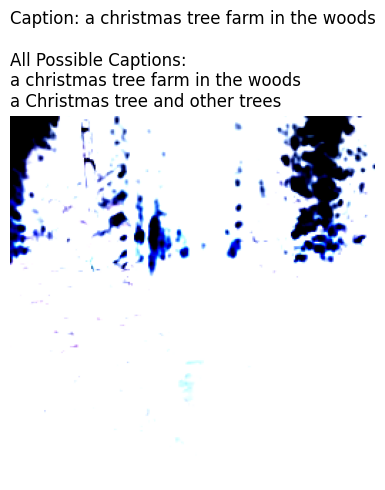

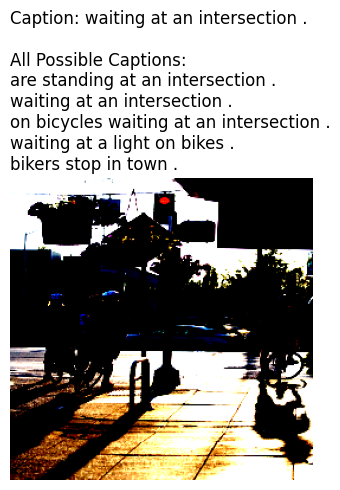

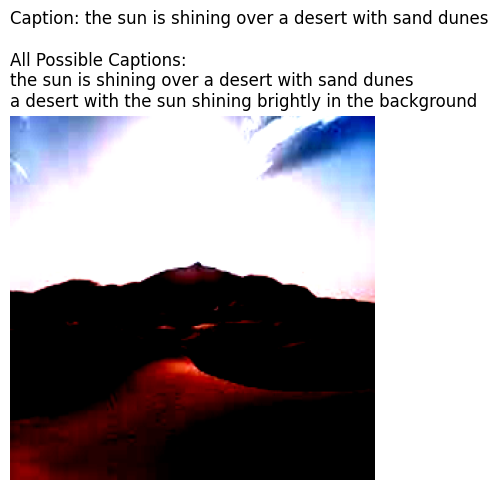

In [117]:
visualise_img_caption_data(train_dataloader, batch_size, dataset, num_samples=3)

### 2. Application of transformer image captioning model
- Implementing a MaxxVit Vison Transformer Encoder and a Transformer Decoder

In [118]:
class EncoderMaxVit(torch.nn.Module):
  """
    An encoder module based on the MaxVit architecture, adapted for image captioning by converting images into dense feature embeddings.

    The final fully connected (fc) layer of the MaxVit model is replaced to map the extracted features to the desired embedding size.
    Feature extraction layer (classifier.5 for pretrained and head for finetuned) is always trainable.

    Args:
      finetuned_model: Finetuned MaxVit model, else None
      embedding_size (int): Embedding Dimension for size of feature embedding
      train_CNN (bool, optional): Determines if the entire MaxVit model will be unfreeze and trained during the training. Defaults to False.
      drop_p (float, optional): Dropout probability to use in the dropout layer for regularization. Defaults to 0.5.
  """
  
  def __init__(self, finetuned_model, embedding_size:int, train_CNN:bool=False, drop_p:float=0.5):
    super(EncoderMaxVit, self).__init__()
    self.embed_size = embedding_size

    if finetuned_model is not None:
      # Initialize custom finetuned model and make the last linear layer trainable
      self.model = list(finetuned_model.children())[0]
      self.model.classifier[-1] = torch.nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=self.embed_size, bias=True)
      #Remove creating feature extraction layer and make it trainable, the rest depends on train_cnn
      for name, param in self.model.named_parameters():
        if "classifier.5.weight" in name or "classifier.5.bias" in name:
          param.requires_grad = True
        else:
          param.requires_grad = train_CNN

    else:
      # Initialize pretrained model and make last linear layer trainable
      model_used = 'maxvit_rmlp_tiny_rw_256.sw_in1k'
      self.model = timm.create_model(model_used, pretrained=True)
      self.model.head.fc = torch.nn.Linear(in_features=self.model.head.fc.in_features, out_features=self.embed_size, bias=True)

      for name , param in self.model.named_parameters():
        if "head.fc.weight" in name or "head.fc.bias" in name:
          param.requires_grad = True
        else:
          param.requires_grad = train_CNN

    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(drop_p)
    
              
  def forward(self, image):
    output = self.model(image)
    output = self.dropout(self.relu(output))
    
    return output

In [119]:
class PositionalEncoding(nn.Module):
  """
    Injects some information about the relative or absolute position of the tokens in the sequence.
    Embeddings do not encode the relative position of tokens in a sentence. 
    With positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sequence, in the d-dimensional space.

    Args:
      d_model (int): The dimension of the embeddings.
      dropout (float, optional): The dropout probability.
      max_len (int, optional): The maximum length of the input sequences.
  """
  
  def __init__(self, d_model: int, dropout: float=0.1, max_len: int=5000):
    super().__init__()

    self.dropout = nn.Dropout(p=dropout)
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    """
      Args:
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

In [120]:

class TransformersDecoder(nn.Module):
  """
    A Transformer-based decoder that generates captions from image features. 
    Uses the features from the encoder as the memory input to the Transformer layers,
    along with the target tokens (captions) which are shifted right.
    It applies positional encoding to the target token embeddings to maintain their sequence information.

    Args:
      embedding_size (int): The size of the embedding vector for each token.
      trg_vocab_size (int): The size of the target vocabulary.
      num_heads (int): The number of heads in the multihead-attention models.
      num_decoder_layers (int): The number of sub-decoder-layers in the decoder.
      dropout (float): The dropout probability.

    The decoder generates predictions for the next token in the sequence, given the current sequence of tokens and the image features.
  """
   
  def __init__(self, embedding_size:int, trg_vocab_size:int, num_heads:int, num_decoder_layers:int, dropout:float):
    super(TransformersDecoder, self).__init__()
    self.num_heads = num_heads

    self.embedding = nn.Embedding(trg_vocab_size, embedding_size)
    self.pos = PositionalEncoding(d_model=embedding_size)
    self.decoder_layer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=num_heads)
    self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
    self.linear = nn.Linear(embedding_size, trg_vocab_size)
    self.drop = nn.Dropout(dropout)
      
  def make_mask(self, sz):
    """
      Generate a square attention mask of size (sz, sz),
      with upper triangular filled with float('-inf').
    """

    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask
  
  def forward(self, features, caption, device):
    embed = self.drop(self.embedding(caption))
    embed = self.pos(embed)
    trg_mask = self.make_mask(caption.size(0)).to(device)
    decoder = self.decoder(tgt = embed , memory = features.unsqueeze(0), tgt_mask = trg_mask )
    output = self.linear(decoder)

    return output

In [121]:
class TransformerEncoderToDecoder(torch.nn.Module):
  """
    MaxVit Encoder with Transformer Decoder

    Args:
        finetuned_model: Finetuned MaxVit model, else None
        embedding_size (int): The size of the embedding vector for the image features and the tokens.
        trg_vocab_size (int): The size of the target vocabulary for the decoder.
        num_heads (int, optional): The number of attention heads in the Transformer decoder. Defaults to 8
        num_decoder_layers (int, optional): The number of layers in the Transformer decoder. Defaults to 6
        dropout (float, optional): The dropout probability used in the Transformer decoder. Defaults to 0.2
        train_cnn (bool, optional): Determines if MaxVit Encoder should be unfreezed. Defaults to False
        device (str, optional): cuda or cpu. Defaults to cuda
  """
  
  def __init__(self, finetuned_model, embedding_size:int, trg_vocab_size:int, num_heads:int=8, num_decoder_layers:int=6, dropout:float=0.2, train_cnn:bool=False, device:str='cuda'):
    super(TransformerEncoderToDecoder,self).__init__()
    self.device = device
    self.encoder = EncoderMaxVit(finetuned_model, embedding_size, train_cnn)
    self.decoder = TransformersDecoder(embedding_size=embedding_size,
                                        trg_vocab_size=trg_vocab_size,
                                        num_heads=num_heads,
                                        num_decoder_layers=num_decoder_layers,
                                        dropout=dropout)
      
  def forward(self, image, caption):
    features = self.encoder(image)
    output = self.decoder(features, caption, self.device)
    return output
  
  #for inference
  def caption_image(self, image, vocabulary, device, max_length=50):
    """
    Generate caption using a greedy algorithm based on image input

    Args:
        image: image input
        vocabulary (Vocabulary): Vocabulary to decode predictions
        device (str): cuda or cpu
        max_length (int, optional): Max length of generated captions. Defaults to 50.

    Returns:
        captions: string caption in a list
        atten_weights: None for transformer
    """
    outputs=[vocabulary.stoi["<SOS>"]]

    for i in range(max_length):
      trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
      image = image.to(device)
      
      with torch.no_grad():
        output = self.forward(image, trg_tensor)
          
      best_guess = output.argmax(2)[-1, :].item()
      outputs.append(best_guess)
      
      if best_guess == vocabulary.stoi["<EOS>"]:
        break

    caption = [vocabulary.itos[idx] for idx in outputs]
    
    return caption[:-1], None

### 3. Application of BLEU and ROGUE

#### Imports

In [122]:
from nltk.translate.bleu_score import corpus_bleu

def get_bleu_score(predicted:list, references:list):
    """
    Calculate the bleu 1-4 score of a corpus

    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {"BLEU1":, "BLEU2": ,"BLEU3": ,"BLEU4": }
    """
    #Tokenize the predictions and references
    predicted = [pred.split() for pred in predicted]
    references = [[ref.split() for ref in refs] for refs in references]


    BLEU1 = corpus_bleu(references, predicted, weights=(1, 0, 0, 0))
    BLEU2 = corpus_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))
    BLEU3 = corpus_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0))
    BLEU4 = corpus_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {"BLEU1": BLEU1, "BLEU2": BLEU2, "BLEU3": BLEU3, "BLEU4": BLEU4}

In [123]:
import evaluate

def get_rouge_score(predicted:list, references:list):
    """
    Calculate the rogue1, rogue2, rogueL, rogueLSum scores
        
    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {'rouge1': , 'rouge2': , 'rougeL': , 'rougeLsum': }
    
    """
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=predicted, references=references)
    return results

### 4. Application of model training, validation and test

#### Imports

In [124]:
def decode_predictions(outputs, batch_first:bool, vocabulary:Vocabulary):
    """
    Function to convert model tensor outputs to sentences

    Args:
        outputs (torch tensor object): Model's output to be decoded, either in size (seq len, batch, vocab_size) or (batch, seq len, vocab_size)
        batch_first (bool): Boolean of if dataloader was configured to batch_first
        vocabulary (Vocabulary): dataset Vocabulary Class for decoding

    Returns:
        list of predicted sentences each corresponding to 1 sample in the batch
            - will be of length (batch_size)
            eg. ['predicted sentence 1 for sample 1', ...'predicted sentence N for sample N']
    
    """

    all_prediction = []
    predicted_tokens = outputs.argmax(-1) #flatten vocab size dimensions
    if not batch_first:
        predicted_tokens = predicted_tokens.T 
    
    for sentence_tokens in predicted_tokens:
        sentence_tokens = sentence_tokens.tolist()

        try:
            #cropping predicted sentence to first EOS
            eos_index = sentence_tokens.index(vocabulary.stoi['<EOS>']) #get first instance of <EOS> to crop sentence accordingly
            predicted_sentence = sentence_tokens[:eos_index]
        except:
            predicted_sentence = sentence_tokens

        try:
            #getting predicted_sentence by remove <SOS>
            predicted_sentence.remove(vocabulary.stoi['<SOS>'])
        except:
            pass
    
        all_prediction.append(" ".join([vocabulary.itos[idx] for idx in predicted_sentence]))

    return all_prediction

In [125]:
def eval(model, 
         criterion, 
         dataloader, 
         image_size:tuple,
         transformer:bool,
         batch_first:bool, 
         vocabulary:Vocabulary, 
         device:str):
    """
    Function to evaluate model performance

    Args:
        model: The model that is to be evaluated
        criterion: Loss criterion of the model
        dataloader: validation / test dataset
        image_size (tuple): image size of model
        transformer (bool): boolean if decoder is a transformer
        batch_first (bool): boolean if dataloader samples tensor are (batch, seq len) or (seq len, batch)
        vocabulary (Vocabulary): dataset vocabulary class
        device (str): cpu or cuda

    Returns:
        avg_val_loss: average validation loss
        Bleu_score: dictionary of BLEU 1-4 score
        Rouge_score: dictionary of Rouge  1,2,L,LSum score
    """
    
    model.eval()

    total_val_loss = 0

    #BLEU predictions container
    predictions = []
    references = []
    
    with torch.no_grad():
        for idx, (imgs, annotations, all_annotations) in enumerate(dataloader):
            #getting img and annotations
            imgs = torch.nn.functional.interpolate(imgs, size=image_size, mode='bilinear') #resize image for model, using same as transforms.resize()
            imgs = imgs.to(device)
            annotations = annotations.to(device)
            
            if transformer:
                #running model prediction
                outputs = model(imgs, annotations[:-1]) #training model to guess the last word
                targets = annotations[1:].reshape(-1)
                #updating model parameters
                loss = criterion(outputs.view(-1, len(vocabulary)), targets)
            
            else:
                if not batch_first:
                    #running model prediction
                    outputs = model(imgs, annotations[:-1]) #training model to guess the last word
                    
                    #updating model parameters
                    loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
                
                if batch_first:
                    #running model prediction
                    outputs, atten_weights = model(imgs, annotations[:, :-1]) #training model to guess the last word
                    targets = annotations[:, 1:]
                    #updating model parameters
                    loss = criterion(outputs.view(-1, len(vocabulary)), targets.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
            
            total_val_loss += loss.item()

            #get model predictions and update
            predictions.extend(decode_predictions(outputs, batch_first, vocabulary))

            #update references
            references.extend(all_annotations)

        Bleu_score = get_bleu_score(predictions, references)
        Rouge_score = get_rouge_score(predictions, references)

        return total_val_loss/(idx+1), Bleu_score, Rouge_score


In [126]:
def train(model, 
          criterion, 
          optimiser, 
          train_dataloader, 
          val_dataloader, 
          image_size: tuple,
          batch_first:bool, 
          transformer:bool,
          vocabulary:Vocabulary, 
          device:str, 
          num_epochs:int, 
          early_stopping_threshold: float=0.003,
          show_train_metrics:bool=None, 
          save_every:int=None,
          model_name:str=None, 
          overwrite:bool=False):
    
    """
    Function to train the model
    If change in val loss is less than 0.01 for 2 epochs in a row, stop training

    Args:
        model: The model that is to be evaluated
        criterion: Loss criterion of the model
        optimiser: Optimiser function of the model
        train_dataloader: Train dataset
        val_dataloader: Validation dataset, use None if no Validation dataset
        image_size (tuple): image size of model
        batch_first (bool): Boolean if dataloader samples tensor are (batch, seq len) or (seq len, batch)
        transformer (bool): Boolean if decoder is a transformer
        vocabulary (Vocabulary): Dataset vocabulary class
        device (str): cpu or cuda
        num_epochs (int): Number of epochs for training
        early_stopping_threshold (float, optional): Threshold for early stopping, defaults to 0.003
        show_train_metrics (bool, optional): Booleon on should calculate BLEU & Rouge score during training, defaults to False
        save_every (int, optional): Save model after every ___ epochs, defaults to None (no saving)
        model_name (str, optional): Model Name to be saved after, required if save_every != None, model will be saved as (model_name)_epoch or just model_name
        overwrite (bool, optional): Boolean on overwriting model saves or saving each specific epoch as a new model, defaults to False
    
    Returns
        train_loss: list of average training loss per epoch
        train_bleu: list of dictionary of training BLEU score per epoch, [] if show_train_metric = False
        train_rouge: list of dictionary of training Rouge score per epoch, [] if show_train_metric = False
        val_loss: list of average validation loss per epoch, [] if val_dataloader = None
        val_bleu: list of dictionary of validation BLEU score per epoch, [] if val_dataloader = None
        val_rouge: list of dictionary of validation Rouge score per epoch, [] if val_dataloader = None
    
    """
    
    #initialise results container
    train_loss = []
    train_bleu = []
    train_rouge = []

    val_loss = []
    val_bleu = []
    val_rouge = []

    for epoch in range(num_epochs):

        total_train_loss = 0

        #BLEU predictions container
        predictions = []
        references = []

        #start model training
        model.train()
        for idx, (imgs, annotations, all_annotations) in enumerate(train_dataloader):
            
            #getting img and annotations
            imgs = torch.nn.functional.interpolate(imgs, size=image_size, mode='bilinear') #resize image for model, using same as transforms.resize()
            imgs = imgs.to(device)
            annotations = annotations.to(device)

            if transformer:
                #running model prediction
                outputs = model(imgs, annotations[:-1]) #training model to guess the last word
                targets = annotations[1:].reshape(-1)
                #updating model parameters
                loss = criterion(outputs.view(-1, len(vocabulary)), targets)
            
            else:
                if not batch_first:
                    #running model prediction
                    outputs = model(imgs, annotations[:-1]) #training model to guess the last word
                    #updating model parameters
                    loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
                
                if batch_first:
                    #running model prediction
                    outputs, atten_weights = model(imgs, annotations[:, :-1]) #training model to guess the last word
                    targets = annotations[:, 1:]
                    #updating model parameters
                    loss = criterion(outputs.view(-1, len(vocabulary)), targets.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
                
            optimiser.zero_grad() #remove optimiser gradient
            loss.backward()
            optimiser.step()
            
            #calculate loss and update it for each batch
            total_train_loss += loss.item()

            if show_train_metrics:
                #get model predictions and update
                predictions.extend(decode_predictions(outputs, batch_first, vocabulary))

                #update references
                references.extend(all_annotations)

        if show_train_metrics:   
            #calculating bleu and rouge score
            Bleu_score = get_bleu_score(predictions, references)
            Rouge_score = get_rouge_score(predictions, references)
            train_bleu.append(Bleu_score)
            train_rouge.append(Rouge_score)

        #updating values
        train_loss.append(total_train_loss/(idx+1))

        if val_dataloader != None:
            #validation
            avg_val_loss, val_bleu_score, val_rouge_score = eval(
                                                                model=model,
                                                                criterion=criterion,
                                                                dataloader=val_dataloader,
                                                                image_size=image_size,
                                                                transformer=transformer,
                                                                batch_first=batch_first,
                                                                vocabulary=vocabulary,
                                                                device=device
                                                            )
            
            val_loss.append(avg_val_loss)
            val_bleu.append(val_bleu_score)
            val_rouge.append(val_rouge_score)

        #printing progress
        if num_epochs <= 10 or (num_epochs >10 and (epoch+1)%5 == 0):
            print(f"Epoch {epoch+1} completed\navg training loss per batch: {total_train_loss/(idx+1)}")
            
            if show_train_metrics:
                print(f"train bleu score:{Bleu_score}\ntrain rouge score: {Rouge_score}\n")

            if val_dataloader != None:
                print(f"avg validation loss per batch: {avg_val_loss}\nval bleu score: {val_bleu_score}\nval rouge score: {val_rouge_score}")

            print("------------------------------------------------------------------")
            
        #saving model every x
        if save_every != None and (epoch+1)%save_every == 0:
            try:
                if overwrite:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}.pt")
                else:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_{epoch+1}.pt")
            except:
                print(f"Unable to save model at epoch {epoch+1}")

        
        #saving best model
        if (len(val_loss) > 1) and val_loss[-1] < min(val_loss[:-1]):
            try:
                torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_best.pt")
            except:
                print(f"Unable to save best model")
        

        #early stopping
        if (len(val_loss) >= 3) and abs(val_loss[-2] - val_loss[-1]) < early_stopping_threshold and abs(val_loss[-3] - val_loss[-2]) < early_stopping_threshold:
            print(f"validation loss did not decrease, stopping training at epoch {epoch +1}")
            try:
                if overwrite:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}.pt")
                else:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_{epoch+1}.pt")
            except:
                print(f"Unable to save model at epoch {epoch+1}")
            break


    return train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge


In [127]:
def visualise_graph(training_data:list, validation_data:list, y_label:str, x_label:str, ylim:list=None):
    """
    Plot a line graph against training and validation data

    Args:
        training_data (list): Training data to be plotted
        validation_data (list): Validation data to be plotted
        y_label (str): Label of y axis
        x_label (str): Label of x axis
        ylim (list, optional): Range of y axis, defaults to None
    """
    #plotting line graph of training data and validation data
    plt.plot(training_data, label='Train')
    plt.plot(validation_data, label='Validation')

    #labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{y_label} against {x_label}')
    
    if ylim != None:
        plt.ylim(ylim)
        
    #show legend
    plt.legend()
    plt.show()

#### Training

In [128]:
# Clear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

23862

#### Import Pretrained

In [129]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

#### Finetuned MaxVit

In [130]:
finetuned_maxvit = torch.load('../models/cnn/maxvit_20_best.pt')

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
img_size = (224,224)
embed_size = 512 
vocab_size = len(dataset.vocab)
num_heads = 8
num_decoder_layers = 4
learning_rate = 3e-4
num_epochs = 100
save_every = 25
dropout = 0.10
model_name = "Finetuned_maxvit_20"

print(device)

cuda


In [132]:
model = TransformerEncoderToDecoder(finetuned_model=finetuned_maxvit,
                                embedding_size=embed_size,
                                trg_vocab_size=vocab_size,
                                num_heads=num_heads,
                                num_decoder_layers=num_decoder_layers,
                                dropout=dropout,
                                train_cnn=False,
                                device=device).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [133]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    image_size=img_size,
    transformer=True,
    batch_first=False,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=2,
    early_stopping_threshold = 0.003,
    show_train_metrics=True,
    save_every=25,
    model_name=model_name,
    overwrite=False
)

Epoch 1 completed
avg training loss per batch: 3.231417806043277
train bleu score:{'BLEU1': 0.5075165363800361, 'BLEU2': 0.2905225649555825, 'BLEU3': 0.16739393272408465, 'BLEU4': 0.09534999422587766}
train rouge score: {'rouge1': 0.42294986052211314, 'rouge2': 0.15827070971054605, 'rougeL': 0.3954930288011767, 'rougeLsum': 0.3954903013865743}

avg validation loss per batch: 2.782321057319641
val bleu score: {'BLEU1': 0.5368599854404271, 'BLEU2': 0.32575569813902583, 'BLEU3': 0.19924934791730892, 'BLEU4': 0.119149946961417}
val rouge score: {'rouge1': 0.4541014039666135, 'rouge2': 0.18946608712031343, 'rougeL': 0.4282428412797517, 'rougeLsum': 0.428235898930424}
------------------------------------------------------------------
Epoch 2 completed
avg training loss per batch: 2.60362865264341
train bleu score:{'BLEU1': 0.5593709206691461, 'BLEU2': 0.34870034703893626, 'BLEU3': 0.21718232226147416, 'BLEU4': 0.13311987782312054}
train rouge score: {'rouge1': 0.46984046640919214, 'rouge2': 

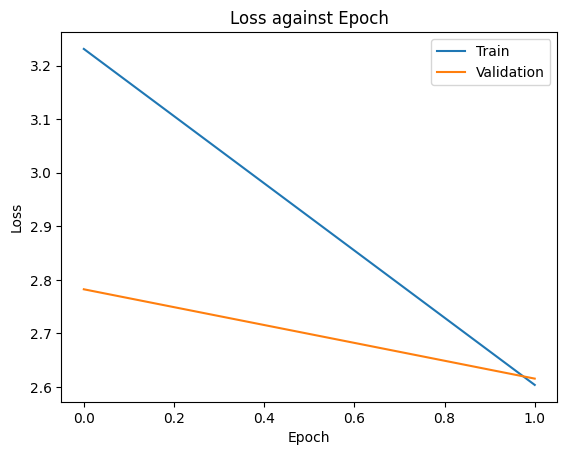

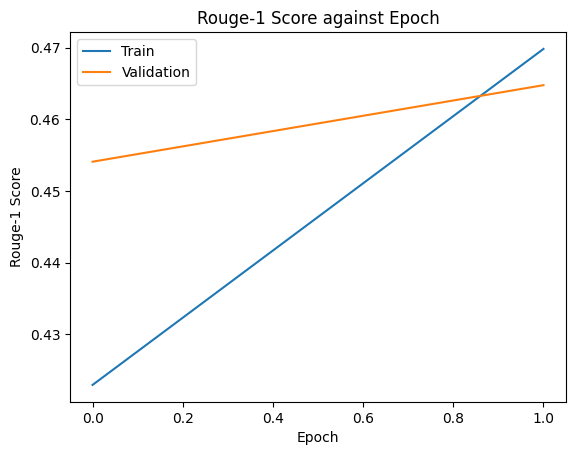

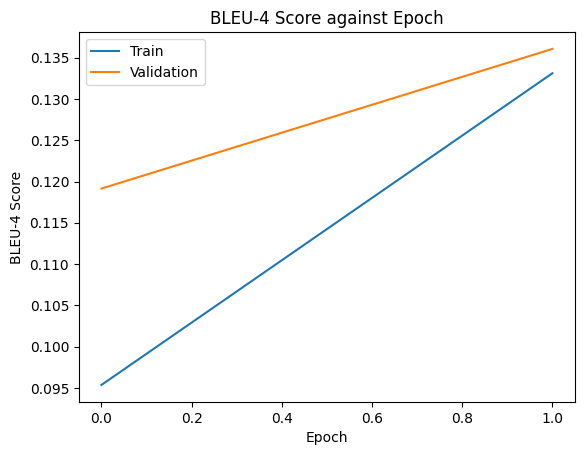

In [134]:
#loss
visualise_graph(training_data=train_loss,
                validation_data=val_loss,
                y_label='Loss',
                x_label='Epoch')

#rouge-1
rouge_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
rouge_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]
visualise_graph(training_data=rouge_train,
                validation_data=rouge_val,
                y_label='Rouge-1 Score',
                x_label='Epoch')

#bleu4
bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]
visualise_graph(training_data=bleu4_train,
                validation_data=bleu4_val,
                y_label='BLEU-4 Score',
                x_label='Epoch')

##### Pretrained MaxVit

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
img_size = (256,256)
embed_size = 512 
vocab_size = len(dataset.vocab)
num_heads = 8
num_decoder_layers = 4
learning_rate = 3e-4
num_epochs = 100
save_every = 25
dropout = 0.10
model_name = "Pretrained_maxvit"

print(device)

cuda


In [136]:
model = TransformerEncoderToDecoder(finetuned_model=None,
                                embedding_size=embed_size,
                                trg_vocab_size=vocab_size,
                                num_heads=num_heads,
                                num_decoder_layers=num_decoder_layers,
                                dropout=dropout,
                                train_cnn=False,
                                device=device).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [137]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    image_size=img_size,
    transformer=True,
    batch_first=False,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=2,
    early_stopping_threshold = 0.003,
    show_train_metrics=True,
    save_every=25,
    model_name=model_name,
    overwrite=False
)

Epoch 1 completed
avg training loss per batch: 3.267291436192323
train bleu score:{'BLEU1': 0.5019560984781857, 'BLEU2': 0.28665734222068046, 'BLEU3': 0.16433968413971284, 'BLEU4': 0.09299941117604171}
train rouge score: {'rouge1': 0.41866434375978373, 'rouge2': 0.15543181097817313, 'rougeL': 0.39132094161965536, 'rougeLsum': 0.3912920530115384}

avg validation loss per batch: 2.7769502849578855
val bleu score: {'BLEU1': 0.544750430292599, 'BLEU2': 0.3368253201920236, 'BLEU3': 0.20561201000977175, 'BLEU4': 0.12105780547380067}
val rouge score: {'rouge1': 0.45654794258056597, 'rouge2': 0.19453279571347132, 'rougeL': 0.4276721132159969, 'rougeLsum': 0.4278478002069323}
------------------------------------------------------------------
Epoch 2 completed
avg training loss per batch: 2.625469786344395
train bleu score:{'BLEU1': 0.5560051926405539, 'BLEU2': 0.3461391399371518, 'BLEU3': 0.21554291634491468, 'BLEU4': 0.1316276008121655}
train rouge score: {'rouge1': 0.46705667769872306, 'rouge

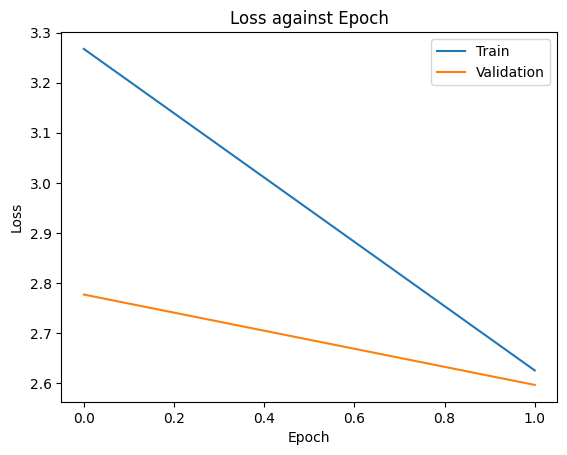

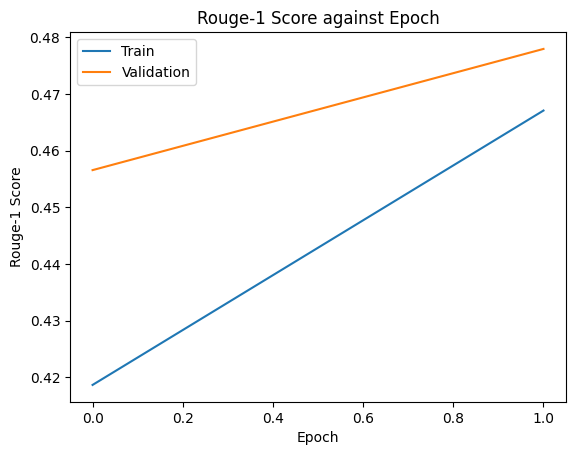

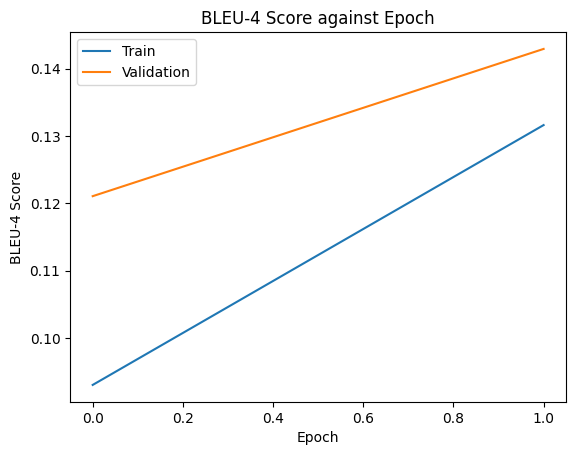

In [138]:
#loss
visualise_graph(training_data=train_loss,
                validation_data=val_loss,
                y_label='Loss',
                x_label='Epoch')

#rouge-1
rouge_train =  [rouge_dict['rouge1'] for rouge_dict in train_rouge]
rouge_val =  [rouge_dict['rouge1'] for rouge_dict in val_rouge]
visualise_graph(training_data=rouge_train,
                validation_data=rouge_val,
                y_label='Rouge-1 Score',
                x_label='Epoch')

#bleu4
bleu4_train =  [bleu_dict['BLEU4'] for bleu_dict in train_bleu]
bleu4_val =  [bleu_dict['BLEU4'] for bleu_dict in val_bleu]
visualise_graph(training_data=bleu4_train,
                validation_data=bleu4_val,
                y_label='BLEU-4 Score',
                x_label='Epoch')

#### Evaluation

In [139]:
# Clear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

11303

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 512 
vocab_size = len(dataset.vocab)
num_heads = 8
num_decoder_layers = 4
dropout = 0.10

print(device)

cuda


In [142]:
finetuned_maxvit = torch.load('../models/cnn/maxvit_20_best.pt')
test_model1 = TransformerEncoderToDecoder(finetuned_model=finetuned_maxvit,
                                embedding_size=embed_size,
                                trg_vocab_size=vocab_size,
                                num_heads=num_heads,
                                num_decoder_layers=num_decoder_layers,
                                dropout=dropout,
                                train_cnn=False).to(device)
test_criterion1 = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
test_model1.load_state_dict(torch.load('../models/image_captioning/Finetuned_maxvit_20_best.pt'))

<All keys matched successfully>

In [144]:
test_model2 = TransformerEncoderToDecoder(finetuned_model=None,
                                embedding_size=embed_size,
                                trg_vocab_size=vocab_size,
                                num_heads=num_heads,
                                num_decoder_layers=num_decoder_layers,
                                dropout=dropout,
                                train_cnn=False).to(device)
test_criterion2 = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
test_model2.load_state_dict(torch.load('../models/image_captioning/Pretrained_maxvit_best.pt'))

<All keys matched successfully>

In [146]:
all_models = [[test_model1, test_criterion1, (224,224)],
              [test_model2, test_criterion2, (256,256)]]


for idx, models in enumerate(all_models):
    test_loss, test_bleu, test_rouge = eval(
                                model=models[0],
                                criterion=models[1],
                                dataloader=test_dataloader,
                                image_size=models[2],
                                transformer=True,
                                batch_first=False,
                                vocabulary=test_dataset.vocab,
                                device=device
                                )
    
    print(f"Test Model {idx}\nTest Loss: {test_loss}\nTest BLEU:{test_bleu}\nTest Rouge:{test_rouge}\n----------------------------------------")


Test Model 0
Test Loss: 2.7498980151846055
Test BLEU:{'BLEU1': 0.5434850258583643, 'BLEU2': 0.33285961879133674, 'BLEU3': 0.20138106888102875, 'BLEU4': 0.118473934857911}
Test Rouge:{'rouge1': 0.44566537998141165, 'rouge2': 0.1826359658337403, 'rougeL': 0.4199057434733303, 'rougeLsum': 0.4199207179644519}
----------------------------------------
Test Model 1
Test Loss: 2.73172205940206
Test BLEU:{'BLEU1': 0.5532157338621363, 'BLEU2': 0.3473136877814542, 'BLEU3': 0.21259475192136532, 'BLEU4': 0.1267383089033328}
Test Rouge:{'rouge1': 0.45854797821368865, 'rouge2': 0.19566196758210658, 'rougeL': 0.431634003001415, 'rougeLsum': 0.4314798331671489}
----------------------------------------


### 5. Application of model inference & multiple model inference
NOTE: the generate captions function should belong to your model class and have your own implementation depending on your model architecture
<br/><br/>
For easy standarisation you please make your `caption_image` function in your class have the following:
1. Inputs: image, vocabulary, device, max_length
2. Outputs: string prediction, attention (or None) 



#### Imports

In [162]:
#Assuming mean and std are defined as follows:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std
    
    Args: 
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean 
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image


def caption_image(model, 
                  dataloader, 
                  image_size:tuple,
                  vocabulary:Vocabulary, 
                  device:str, 
                  mean:np.array=np.array([0.485, 0.456, 0.406]), 
                  std:np.array=np.array([0.229, 0.224, 0.225]), 
                  num_batches:int=1, 
                  num_images:int=5, 
                  max_length:int=50, 
                  show_plot:bool=False):
    """
    Function to generate model predictions from a dataloader

    Arg:
        model: model to general model prediction (ensure that your model has the function caption_image)
        dataloader: dataset to generate prediction
        image_size (tuple): image size of images for the model
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the list of all generated captions and actual captions
    
    """
    model.eval()
    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': [], 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))

        #take first k from batch
        for i in range(num_images):
            features = torch.nn.functional.interpolate(features, size=image_size, mode='bilinear') #resize image for model, using same as transforms.resize()
            image = features[i].unsqueeze(0).to(device)
            
            #generate captions from model
            generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
            
            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f'Model Prediction:\n{" ".join(generated_caption[1:-1])}\n\nAll Possible Predictions:\n' + "\n".join(all_annotations[i]), loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Predicted'].append(generated_caption)
            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions


def multiple_model_captions(
        model_list:list[str, tuple],
        dataloader, 
        vocabulary:Vocabulary, 
        device:str, 
        mean:np.array=np.array([0.485, 0.456, 0.406]), 
        std:np.array=np.array([0.229, 0.224, 0.225]), 
        num_batches:int=1, 
        num_images:int=5, 
        max_length:int=50, 
        show_plot:bool=False):
    """
    Function to generate model predictions for multiple models from the same dataloader

    Arg:
        model_list (list[str, tuple]): list of [model, img_size] to general model prediction (ensure that your model has the function caption_image)
            eg. [[model1, (224,224)], [model2, (256,256)]]
        dataloader: dataset to generate prediction
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        mean (np.array): Numpy array of the mean used for normalisation
        std (np.array): Numpy array of the std used for normalisation
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    Returns:
        all_predictions (dict): Dictionary containing the dictionary of all generated captions for each model and list of actual captions
    
    """
    for model, img_size in model_list:
        model.eval()

    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': {}, 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))
        
        #take first k from batch
        for i in range(num_images):
            image = features[i].unsqueeze(0).to(device)
            all_captions = []

            for idx, (model, img_size) in enumerate(model_list):
                #resize image
                image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') #resize image
                #generate captions from model
                generated_caption, attention = model.caption_image(image, vocabulary, device, max_length=max_length)
                all_captions.append(" ".join(generated_caption[1:-1]))
                model_predictions = all_predictions['Predicted'].get(f"model_{idx}", [])
                model_predictions.append(all_captions)
                all_predictions['Predicted'][f"model_{idx}"] = model_predictions

            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = unnormalize(img, mean, std)  # Unnormalize the image
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')

                pred = '\n'.join(all_captions)
                annotation = '\n'.join(all_annotations[i])

                ax.set_title(f'All Model Predictions:\n{pred}\n\nAll Possible Predictions:\n{annotation}', loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions

#### Inference

##### Multi-model

In [163]:
model_list = [[test_model1, (224,224)],
              [test_model2, (256,256)]]

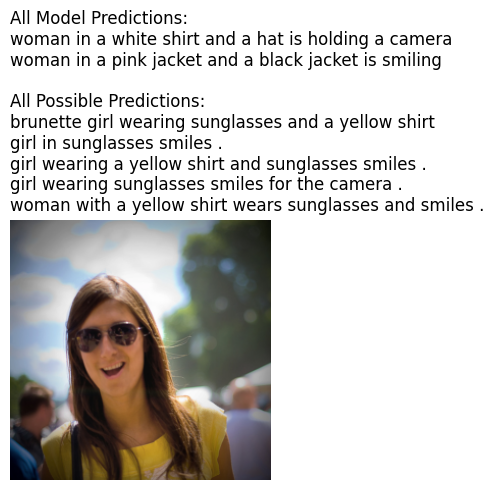

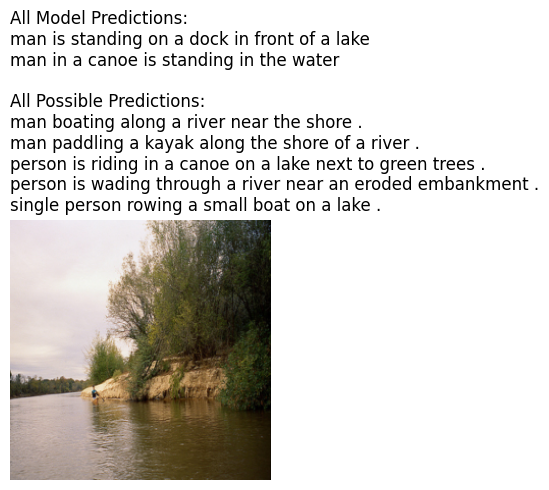

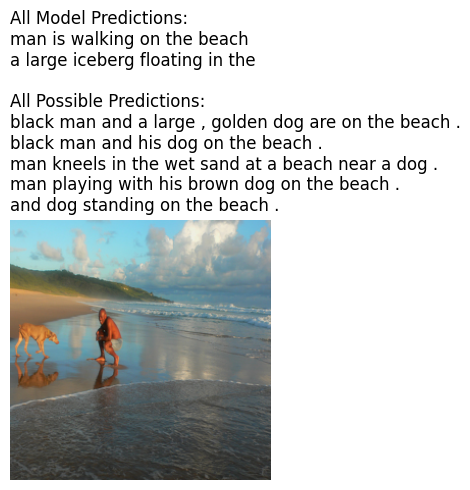

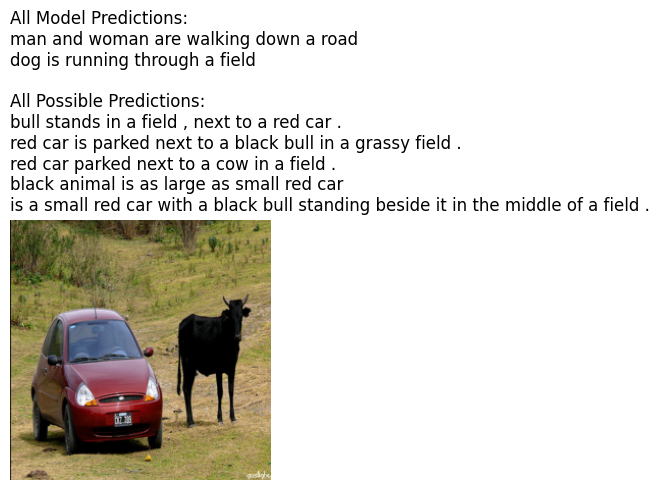

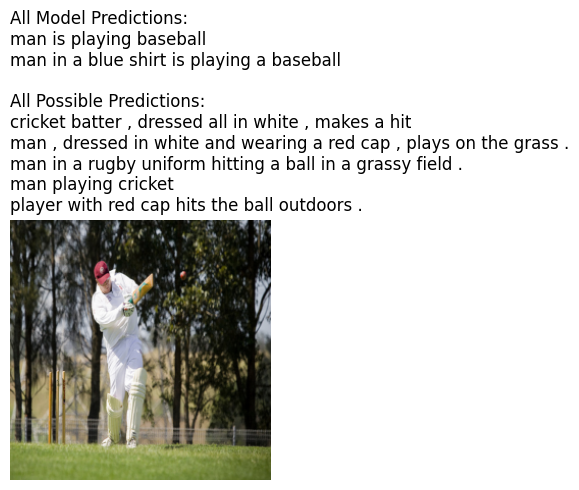

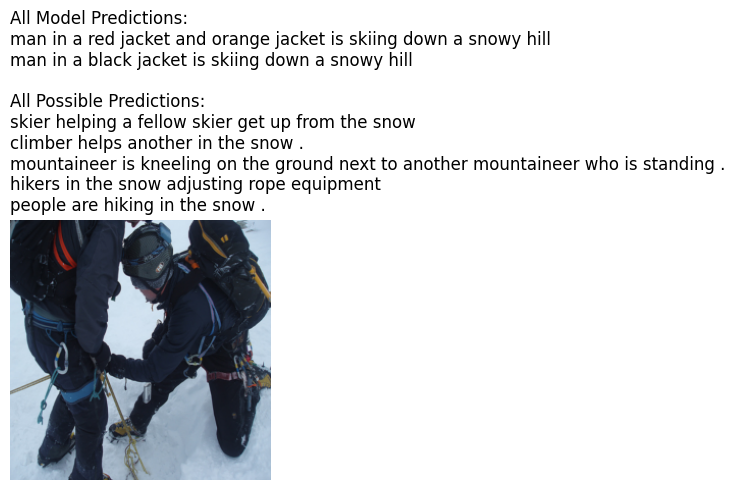

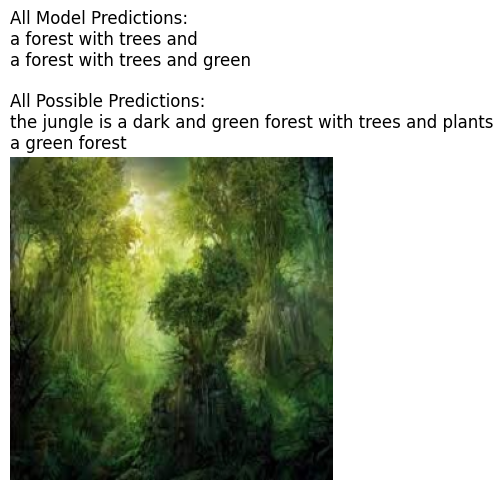

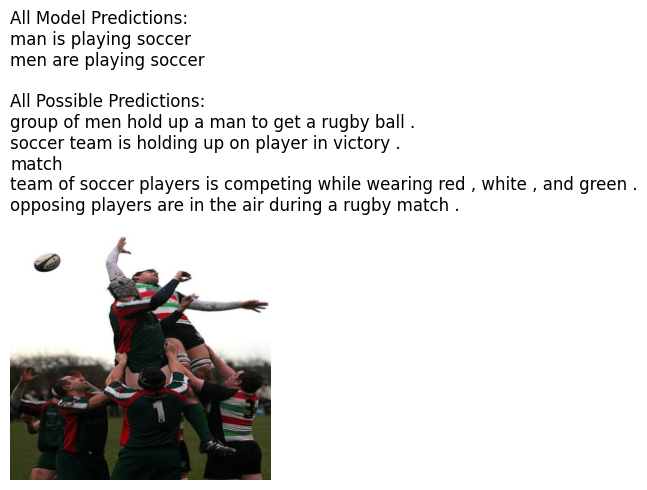

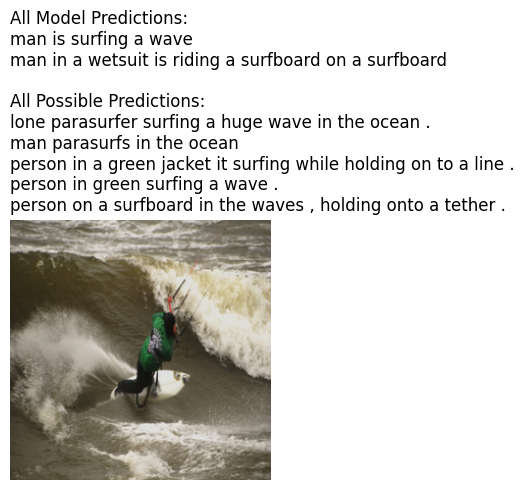

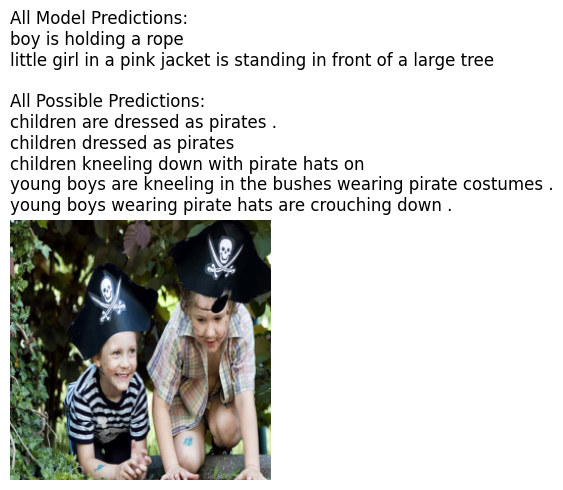

In [164]:
predictions = multiple_model_captions(
    model_list=model_list,
    dataloader=test_dataloader,
    vocabulary= test_dataset.vocab,
    device=device,
    mean=mean,
    std=std,
    num_batches=10,
    num_images=1,
    max_length=50,
    show_plot=True
)

##### Single Model

In [ ]:
predictions = caption_image(
    model=test_model1,
    dataloader=test_dataloader,
    image_size=(224,224),
    vocabulary=test_dataset.vocab,
    device=device,
    mean=mean,
    std=std,
    num_batches=1,
    num_images=10,
    max_length=50,
    show_plot=True
)